In [2]:
### Script for Pathway enrichment analysis on MOFA results; requires a prepared pathway set input dataset

#############################################
# Prerequisites - Load Libraries

In [3]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/mofa_analysis//lib/R/library"


‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::betwee

In [4]:
source('MS2_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [5]:
source('MS1_Functions.r')

###############################################
# Preqrequisites Configurations & Parameters

In [6]:
### Load the parameters that are set via the configuration files

In [7]:
### Load configurations file
global_configs = read.csv('configurations/Data_Configs.csv', sep = ',')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'configurations/Data_Configs.csv'”


In [8]:
head(global_configs,2)

,parameter,value
,<chr>,<chr>
1,data_path,/lustre/groups/epigenereg01/workspace/projects/jove/input_data/
2,result_path,/lustre/groups/epigenereg01/workspace/projects/jove/results/


In [9]:
data_path = global_configs$value[global_configs$parameter == 'data_path']

In [10]:
data_path

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/input_data/"

In [11]:
result_path = global_configs$value[global_configs$parameter == 'result_path']

In [12]:
result_path

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results/"

In [13]:
### Load the configuration for the pathway enrichment from the config file

In [14]:
pathway_configs = read.csv('configurations/06_Pathway_Configs.csv', sep = ',')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'configurations/06_Pathway_Configs.csv'”


In [15]:
head(pathway_configs)

,mofa_result_name,factor_set,coverage_par,types,coverage_plot,p_value_plot,max_pathways_plot,enrichment_plot,top_features_plot,pathway_selection
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<lgl>
1,MI_v1_MOFA,"1,2,3,4,5",0.2,"B.cell,CD16.Mono,CD4.CTL,CD4.Naive,CD4.TCM,CD4.TEM,cDC2,gdT,neutrophil,NK,Treg",0.5,0.05,8,positive,0.125,NA


In [16]:
### Generate the result data directory if it does not exist yet
if(!file.exists(paste0(result_path, '06_results'))){
    dir.create(file.path(paste0(result_path, '06_results')))
    }

# Define parameters 

In [17]:
### Save values from loaded config file in variables

In [18]:
## For the calculation of the pathway enrichment

In [19]:
mofa_name = pathway_configs$mofa_result_name[1]   # mofa results that should be used

In [20]:
factor_set = as.numeric(unlist(str_split(pathway_configs$factor_set[1], ',')))  # factors for which enrichment analysis should be executed

In [21]:
coverage_par = pathway_configs$coverage_par[1] # coverage parameter: how many of the genes of a pathway need to be included in the MOFA feature set for testing this pathway for enrichment

In [22]:
views_set = unlist(str_split( pathway_configs$types[1], ','))  # extract the views for which a view-specific pathway enrichment analysis should be executed

In [23]:
views_set

[1] "B.cell"     "CD16.Mono"  "CD4.CTL"    "CD4.Naive"  "CD4.TCM"   
 [6] "CD4.TEM"    "cDC2"       "gdT"        "neutrophil" "NK"        
[11] "Treg"

In [24]:
## Parameters for the visualization of pathways

In [25]:
### Select pathways based on thresholds (like coverage, p-value, direction of enrichment)
coverage_par = pathway_configs$coverage_plot[1]
p_value_cutoff_plot =pathway_configs$p_value_plot[1]
max_pathways =pathway_configs$max_pathways_plot[1]
select_enrichment = pathway_configs$enrichment_plot[1]

### Alternative: select pathways based on their specified names
pathway_selection_var =pathway_configs$pathway_selection[1]

In [26]:
pathway_selection_var

[1] NA

In [27]:
### For visualization define which genes should be ploted (need to be among the top x% of features for the Factor)
top_var_thres =pathway_configs$top_features_plot[1] # choose threshold of top x % of features of MOFA factor to take into account

In [28]:
## Fixed parameters (may be modified here)

In [29]:
## For enrichment calculation
use_statistic = "rank.sum" # which statistic to use to calcuate the enrichment; alternatives: mean.diff, rank.sum
use_test = 'parametric'  # which test to use to test the enrichment; alternatives: permutation, parametric, "cor.adj.parametric"
p_val_cutoff = 0.05
min_size = 5

# Load Data 

## Model Data

In [30]:
### Load the trained MOFA Model

In [31]:
model_name =  paste0("03_MOFA_MODEL_", mofa_name,'.hdf5')

In [32]:
outfile = file.path( paste0(result_path, '/03_results/',  model_name) )

In [33]:
outfile

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//03_results/03_MOFA_MODEL_MI_v1_MOFA.hdf5"

In [34]:
model <- load_model(outfile, verbose = TRUE)

Loading data...

Loading expectations for 2 nodes...

Loading model options...

Loading training options and statistics...

Assigning names to the different dimensions...

Re-ordering factors by their variance explained...

Doing quality control...

Checking views names...

Checking groups names...

Checking samples names...

Checking features names...

Checking dimensions...

Checking there are no features with complete missing values...

Checking sample covariates...

Checking expectations...

Checking for intercept factors...

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 5, 9, 18 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”
Checking for highly correlated factors...



## Pathways

In [35]:
### Load the pre-defined pathway set( needs to include the columns:
# ID (unique identifier of the pathway)
# gene : gene-symbol of the gene belonging to the pathway (will be matched to the MOFA features)
# pathway_name: a textual description of the pathway 

In [36]:
pathways =  read.csv(paste0(data_path, 'Prepared_Pathway_Data.csv'))
pathways$X = NULL

In [37]:
head(pathways,2)

,ID,gene,pathway_name
,<chr>,<chr>,<chr>
1,R-HSA-1059683,JAK1,Interleukin-6 signaling
2,R-HSA-1059683,STAT1,Interleukin-6 signaling


# Prepare model data

## Extract the weights from the model

In [38]:
### Get the feature weights from the model and prepare the format

In [39]:
weights = get_weights(model, views = "all", factors = "all")
weight_data = data.frame()
for (i in names(weights)){
    data = data.frame(weights[[i]])
    data$type = i
    weight_data = rbind(weight_data,data)
}
weight_data$variable_name = rownames(weight_data)
weight_data$view <- weight_data$type 
weight_data$gene = sapply(strsplit(weight_data$variable_name, "_"), "[", 3)
head(weight_data)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name,view,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
B.cell__ACTB,-0.18622572,0.2532893,0.16641189,-0.052115239,-0.12850895,-0.04607836,0.29499641,-0.014377703,0.0030737847,-0.23742092,⋯,0.08731972,0.022657087,-0.013662204,0.02398114,0.25733860,-0.33695142,B.cell,B.cell__ACTB,B.cell,ACTB
B.cell__ACTG1,-0.05929283,-0.0210286,0.12941701,-0.006415541,-0.10125865,-0.02679262,0.17690643,-0.012719177,-0.0073429115,0.05831917,⋯,0.07711172,0.065671454,-0.008466872,0.23901791,0.71884011,0.04404755,B.cell,B.cell__ACTG1,B.cell,ACTG1
B.cell__ACTR2,-0.03962156,0.2723610,0.07830457,-0.174129744,0.03383196,0.08418610,0.58085032,0.006520657,0.0005309017,-0.34673154,⋯,-0.56082421,0.050565496,-0.009194180,0.39254573,0.33316832,-0.31498583,B.cell,B.cell__ACTR2,B.cell,ACTR2
B.cell__ACTR3,0.06087441,0.0377486,-0.06697696,-0.317071164,-0.01804716,-0.06606528,0.01939307,-0.037956857,0.0048412515,0.02484377,⋯,-0.20704329,0.006030756,-0.111238155,0.30912416,0.17350324,0.19337951,B.cell,B.cell__ACTR3,B.cell,ACTR3
B.cell__ADD3,-0.08900485,0.1829813,0.05449551,-0.208797754,-0.03130545,-0.04623831,0.07433143,0.008030978,-0.0080186938,-0.26903606,⋯,0.06001593,-0.036961132,-0.281694254,0.13583734,0.12275302,0.08883714,B.cell,B.cell__ADD3,B.cell,ADD3
B.cell__AES,0.16131069,-0.1939779,0.02168047,0.164927176,-0.15197433,0.16541432,0.03628287,0.030639418,-0.0121872510,-0.25716339,⋯,0.03850664,0.052330404,0.037598427,0.75380586,0.05670264,-0.10799185,B.cell,B.cell__AES,B.cell,AES


In [40]:
## Transform to long format

In [41]:
feature_weights_long = melt(weight_data)

Using type, variable_name, view, gene as id variables



In [42]:
head(feature_weights_long,2)

,type,variable_name,view,gene,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,B.cell,B.cell__ACTB,B.cell,ACTB,Factor1,-0.18622572
2,B.cell,B.cell__ACTG1,B.cell,ACTG1,Factor1,-0.05929283


## Adjust feature names in the model

In [43]:
### Feature names should map to the genes in the pathway set (therefore the view component is  removed)

In [44]:
head(features_names(model)[[1]] )

[1] "B.cell__ACTB"  "B.cell__ACTG1" "B.cell__ACTR2" "B.cell__ACTR3"
[5] "B.cell__ADD3"  "B.cell__AES"

In [45]:
model_conc = model ## save original model for later
for(i in names(features_names(model))){   
        features_names(model)[[i]] = with(feature_weights_long, gene[match(features_names(model)[[i]], variable_name)])
    }

In [46]:
head(features_names(model)[[1]] )

[1] "ACTB"  "ACTG1" "ACTR2" "ACTR3" "ADD3"  "AES"

## Create a MOFA model for the overall enrichment analysis across views

In [47]:
# We need a model that has features of all views concatenated in a single view

In [48]:
views <- names(features_names(model_conc))
tmp <- sapply(views, function(view) model_conc@intercepts[[view]]$group1)
names(tmp) <- NULL  
model_conc@intercepts[['complete']]$group1 = unlist(tmp)
model_conc@expectations$W[['complete']] = do.call(rbind, lapply(views, function(view) model_conc@expectations$W[[view]]))
model_conc@features_metadata = rbind(model_conc@features_metadata, 
                                     data.frame(feature = model_conc@features_metadata$feature, view="complete"))
model_conc@dimensions$D['complete'] = sum(model_conc@dimensions$D)
model_conc@data[['complete']]$group1 = do.call(rbind, lapply(views, function(view) model_conc@data[[view]]$group1))
model_conc@data_options$views = c(model_conc@data_options$views , 'complete')
model_conc@model_options$likelihoods['complete'] = 'gaussian'
model_conc@dimensions$M = length(views) + 1

model_conc@cache$variance_explained$r2_total$group1['complete'] = mean(model_conc@cache$variance_explained$r2_total$group1)
model_conc@cache$variance_explained$r2_per_factor$group1 = cbind(model@cache$variance_explained$r2_per_factor$group1, data.frame('complete' = rowMeans(model_conc@cache$variance_explained$r2_per_factor$group1)))

In [49]:
model_conc

Trained MOFA with the following characteristics: 
 Number of views: 18 
 Views names: B.cell CD14.Mono CD16.Mono CD4.CTL CD4.Naive CD4.TCM CD4.TEM CD8.Naive CD8.TEM cDC2 clinical cytokine gdT neutrophil NK proteomic Treg complete 
 Number of features (per view): 686 1589 1059 542 473 661 737 397 570 280 4 66 218 981 508 490 364 9625 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 128 
 Number of factors: 20 


# Prepare pathway data

In [50]:
### Prepare the pathway data to use for the enrichment

In [51]:
head(pathways,2)

,ID,gene,pathway_name
,<chr>,<chr>,<chr>
1,R-HSA-1059683,JAK1,Interleukin-6 signaling
2,R-HSA-1059683,STAT1,Interleukin-6 signaling


## Filter pathways out based on coverage

In [52]:
## get all features included in the MOFA model
mofa_genes = data.frame(gene = unique(feature_weights_long$gene), is_feature = 1)

In [53]:
head(mofa_genes,2)

,gene,is_feature
,<chr>,<dbl>
1,ACTB,1
2,ACTG1,1


In [54]:
### Merge features within mofa model to pathways
feature_set = merge(pathways, mofa_genes, all.x = TRUE)  

In [55]:
head(feature_set,2)

,gene,ID,pathway_name,is_feature
,<chr>,<chr>,<chr>,<dbl>
1,A1BG,R-HSA-168256,Immune System,1
2,A1BG,R-HSA-6798695,Neutrophil degranulation,1


In [56]:
### Remove pathways for which we have not a high amount of genes in our data (coverage_par)
filter = feature_set %>% group_by(ID, pathway_name) %>% summarise(gene_amount = n(),matched_amount = sum(!is.na(is_feature)),  coverage = sum(!is.na(is_feature)) / n()) %>% filter(coverage >=  coverage_par)

### Get the pathways that have been filtered out because of to low coverage
filtered_pathways = feature_set %>% group_by(ID, pathway_name) %>% summarise(gene_amount = n(),matched_amount = sum(!is.na(is_feature)),  coverage = sum(!is.na(is_feature)) / n()) %>% filter(coverage <  coverage_par)
nrow(filtered_pathways)  # amount of pathways that have een filtred out

`summarise()` has grouped output by 'ID'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'ID'. You can override using the `.groups`
argument.


[1] 137

In [57]:
feature_set = merge(feature_set, filter)

In [58]:
# Overview pathways that have been excluded from testing due to low amount of matching genes
head(filtered_pathways,15) 

ID,pathway_name,gene_amount,matched_amount,coverage
<chr>,<chr>,<int>,<int>,<dbl>
R-HSA-1168372,Downstream signaling events of B Cell Receptor (BCR),101,39,0.3861386
R-HSA-1169091,Activation of NF-kappaB in B cells,73,25,0.3424658
R-HSA-1169092,Activation of RAS in B cells,7,3,0.4285714
R-HSA-1169408,ISG15 antiviral mechanism,72,22,0.3055556
R-HSA-1169410,Antiviral mechanism by IFN-stimulated genes,80,23,0.2875000
R-HSA-1170546,Prolactin receptor signaling,21,3,0.1428571
R-HSA-1222556,ROS and RNS production in phagocytes,36,16,0.4444444
R-HSA-1236974,ER-Phagosome pathway,100,46,0.4600000
R-HSA-1236975,Antigen processing-Cross presentation,164,70,0.4268293


In [59]:
### Remove NA entries for not mapped genes in feature set

In [60]:
head(feature_set,2)

,ID,pathway_name,gene,is_feature,gene_amount,matched_amount,coverage
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
1,R-HSA-1059683,Interleukin-6 signaling,CBL,NA,15,11,0.7333333
2,R-HSA-1059683,Interleukin-6 signaling,STAT1,1,15,11,0.7333333


In [61]:
feature_set = feature_set[!is.na(feature_set$is_feature),]

In [62]:
nrow(feature_set)

[1] 1100

In [63]:
head(feature_set,2)

,ID,pathway_name,gene,is_feature,gene_amount,matched_amount,coverage
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
2,R-HSA-1059683,Interleukin-6 signaling,STAT1,1,15,11,0.7333333
3,R-HSA-1059683,Interleukin-6 signaling,SOCS3,1,15,11,0.7333333


In [64]:
### Save coverage for later usage
coverage_info = unique(feature_set[,c('ID', 'pathway_name', 'coverage')])

In [65]:
### Get genes that are not mapped / and add a not mapped pathway to use them in the background later
# (this is for including all features that are in the MOFA model in the enrichment analysis, either as belonging to a pathway or only being part of the background set)

In [66]:
non_pathway_genes = unique(mofa_genes$gene[!mofa_genes$gene %in% unique(feature_set$gene)])

In [67]:
add_pathway = data.frame(ID = 'Background', pathway_name = 'Background', gene = non_pathway_genes, 
                         is_feature = 1, gene_amount = length(non_pathway_genes), matched_amount =  length(non_pathway_genes),
                         coverage = 1)

In [68]:
feature_set = rbind(feature_set, add_pathway)

## Transform to binary matrix format

In [69]:
### Transform the pathway feature set to a binary matrix format (1 indicating that a certain feature belongs to the pathway; 0 that it does not)

In [70]:
head(feature_set,2)

,ID,pathway_name,gene,is_feature,gene_amount,matched_amount,coverage
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
2,R-HSA-1059683,Interleukin-6 signaling,STAT1,1,15,11,0.7333333
3,R-HSA-1059683,Interleukin-6 signaling,SOCS3,1,15,11,0.7333333


In [71]:
feature_set$pathway_id = paste0(feature_set$ID, '_', feature_set$pathway_name)

In [72]:
feature_set$value = 1

In [73]:
### Adjust names for overall approach (concatenate gene names with cell-types and match to pathways)

In [74]:
feature_weights_long_mapped_join = unique(feature_weights_long[,c('gene', 'variable_name')])

In [75]:
head(feature_weights_long_mapped_join,2)

,gene,variable_name
,<chr>,<chr>
1,ACTB,B.cell__ACTB
2,ACTG1,B.cell__ACTG1


In [76]:
feature_set_all = merge(feature_set, feature_weights_long_mapped_join, by.x = 'gene', by.y = 'gene')

In [77]:
nrow(feature_set_all)

[1] 12263

In [78]:
### Binarize feature set to use in type-specific enrichment

In [79]:
## Based on gene-name for overall enrichment

feature_set = unique(feature_set[,c('pathway_id', 'gene', 'value')]) %>% dcast(pathway_id ~ gene, value.var = 'value')
feature_set[is.na(feature_set)]= 0

In [80]:
head(feature_set,2)

,pathway_id,A1BG,A2M,AAK1,AATK,ABCA7,ABHD17A,ABHD2,ABHD5,ABI1,⋯,ZNF331,ZNF385A,ZNF467,ZNF511.PRAP1,ZNF706,ZNFX1,ZNHIT1,ZRANB2,ZSWIM6,ZYX
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Background_Background,0,1,1,1,1,1,1,1,0,⋯,1,1,1,1,1,1,1,1,1,1
2,R-HSA-1059683_Interleukin-6 signaling,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [81]:
### Binarize feature set to use in overall enrichment

In [82]:
feature_set_all = unique(feature_set_all[,c('pathway_id', 'variable_name', 'value')]) %>% dcast(pathway_id ~ variable_name, value.var = 'value')
feature_set_all[is.na(feature_set_all)] = 0

In [83]:
head(feature_set_all,2) # feature set containing only genes

,pathway_id,B.cell__ACTB,B.cell__ACTG1,B.cell__ACTR2,B.cell__ACTR3,B.cell__ADD3,B.cell__AES,B.cell__AFF3,B.cell__AHNAK,B.cell__AKAP13,⋯,Treg__VIM,Treg__YBX1,Treg__YPEL5,Treg__YWHAB,Treg__YWHAZ,Treg__ZC3HAV1,Treg__ZFAS1,Treg__ZFP36,Treg__ZFP36L2,Treg__ZNF331
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Background_Background,0,0,0,0,1,1,1,1,1,⋯,0,1,0,0,0,1,1,1,1,1
2,R-HSA-1059683_Interleukin-6 signaling,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [84]:
## Adjust rownames and convert to matrix

In [85]:
rownames(feature_set) = feature_set$pathway_id
rownames(feature_set_all) = feature_set_all$pathway_id

In [86]:
feature_set$pathway_id = NULL
feature_set_all$pathway_id = NULL

In [87]:
feature_set = as.matrix(feature_set)
feature_set_all = as.matrix(feature_set_all)

# Run pathway enrichment

## Per View

In [88]:
## For each view seperately run the enrichment

In [89]:
if(max(views_set) != ''){
    enrichment_result_types = run_enrichment_pathway(
        model = model, # MOFA Model
        factor_set = factor_set, # list of factors for which to run the enrichment
        views = views_set,
        use_statistic = use_statistic, # which statistic to use
        feature_set = feature_set, # Pathway Feature Set mapping; here use without type names
        min_size = min_size, # Min size of genes within a pathway
        use_test = use_test, # test used for calculating p-value
        p_val_cutoff = p_val_cutoff, # p-value cutoff used
        enrichment_result_p_val = data.frame())# dataset for saving result 
    } else{enrichment_result_types = ''}

Intersecting features names in the model and the gene set annotation results in a total of 686 features.


Running feature set Enrichment Analysis with the following options...
View: B.cell 
Number of feature sets: 13 
Set statistic: rank.sum 
Statistical test: parametric 





Using pathway as id variables

Using pathway as id variables

Intersecting features names in the model and the gene set annotation results in a total of 686 features.


Running feature set Enrichment Analysis with the following options...
View: B.cell 
Number of feature sets: 13 
Set statistic: rank.sum 
Statistical test: parametric 


Subsetting weights with negative sign




Using pathway as id variables

Using pathway as id variables

Intersecting features names in the model and the gene set annotation results in a total of 686 features.


Running feature set Enrichment Analysis with the following options...
View: B.cell 
Number of feature sets: 13 
Set statistic: rank.sum 
Statistical test: parametric 


Sub

In [90]:
# Example of the resulting enrichment table

In [91]:
if(is.data.frame(enrichment_result_types)){
    head(enrichment_result_types  %>% arrange(padj) ,5)}

,pathway,variable,p,padj,view,enrichment,global_FDR
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,R-HSA-6798695_Neutrophil degranulation,Factor4,6.436162e-05,0.001480317,CD16.Mono,negative,0.1390211
2,R-HSA-6798695_Neutrophil degranulation,Factor3,5.712136e-04,0.007425777,B.cell,positive,0.3596694
3,R-HSA-6798695_Neutrophil degranulation,Factor4,1.413827e-03,0.009189873,NK,negative,0.5089776
4,R-HSA-6798695_Neutrophil degranulation,Factor1,6.560674e-04,0.010681023,CD16.Mono,positive,0.3596694
5,Background_Background,Factor4,8.325681e-04,0.011655953,CD4.TEM,positive,0.3596694


## Across Views

In [92]:
## Run an enrichment analysis across all the views

In [93]:
enrichment_result_all = run_enrichment_pathway(
    model = model_conc, # MOFA Model
    views = 'complete', # dimensions for which to run
    factor_set = factor_set, # list of factors for which to run the enrichment
    use_statistic = use_statistic, # which statistic to use
    feature_set = feature_set_all, # Pathway Feature Set mapping; use the concatenated one with cell-types
    min_size = min_size, # Min size of genes within a pathway
    use_test = use_test, # test used for calculating p-value
    p_val_cutoff = p_val_cutoff, # p-value cutoff used
    enrichment_result_p_val = data.frame()) # dataset for saving results

Warning message in run_enrichment(model, view = i, factors = factor_set, set.statistic = c(use_statistic), :
“7 features were removed because they had no variance in the data.
”
Intersecting features names in the model and the gene set annotation results in a total of 9618 features.


Running feature set Enrichment Analysis with the following options...
View: complete 
Number of feature sets: 52 
Set statistic: rank.sum 
Statistical test: parametric 





Using pathway as id variables

Using pathway as id variables

Warning message in run_enrichment(model, view = i, factors = factor_set, set.statistic = c(use_statistic), :
“7 features were removed because they had no variance in the data.
”
Intersecting features names in the model and the gene set annotation results in a total of 9618 features.


Running feature set Enrichment Analysis with the following options...
View: complete 
Number of feature sets: 52 
Set statistic: rank.sum 
Statistical test: parametric 


Subsetting weights wi

In [94]:
head(enrichment_result_all %>% arrange(padj) ,5)

,pathway,variable,p,padj,view,enrichment,global_FDR
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,R-HSA-166658_Complement cascade,Factor1,2.703981e-11,1.406070e-09,complete,all,2.109105e-08
2,R-HSA-2029482_Regulation of actin dynamics for phagocytic cup formation,Factor4,4.879449e-10,2.537313e-08,complete,negative,1.902985e-07
3,R-HSA-977606_Regulation of Complement cascade,Factor1,1.506145e-09,3.915978e-08,complete,all,3.915978e-07
4,R-HSA-5686938_Regulation of TLR by endogenous ligand,Factor3,3.142539e-09,1.634120e-07,complete,negative,5.424413e-07
5,R-HSA-1236973_Cross-presentation of particulate exogenous antigens (phagosomes),Factor1,3.477188e-09,1.808138e-07,complete,positive,5.424413e-07


In [95]:
### Combine both versions and save the result

In [96]:
if(is.data.frame(enrichment_result_types)){
    enrichment_result = rbind(enrichment_result_all, enrichment_result_types  )
    } else{enrichment_result = enrichment_result_all}

In [97]:
enrichment_result$ID = str_replace(enrichment_result$pathway, '_.*', '')
enrichment_result$pathway_name = str_replace(enrichment_result$pathway, '.*_', '')

In [98]:
enrichment_result$pathway = NULL

In [99]:
enrichment_result = merge(enrichment_result, coverage_info)

In [100]:
write.csv(enrichment_result, paste0(result_path, '/06_results/06_Pathway_Enrichment_' ,mofa_name, '.csv'), row.names = FALSE)

# Plot interesting pathways

In [101]:
## Plot a subset of the enriched pathways (based on the parameters of the config file)

In [102]:
pathway_selection_var  # specifies whether a specific pathway has been selected in the config file

[1] NA

In [103]:
# specifies whether pathways will be displayed based on p-value and coverage thresholds specified in the config file
# or specifically selected pathways will be shown
if(pathway_selection_var == '' | is.na(pathway_selection_var) ){
    pathways_selection = enrichment_result[
        (enrichment_result$coverage > coverage_par) & 
        (enrichment_result$enrichment == select_enrichment) &
        (enrichment_result$global_FDR < p_value_cutoff_plot),] %>%  arrange(padj) %>% group_by(variable) %>% top_n(max_pathways, -padj)
    } else{ pathways_selection = enrichment_result[enrichment_result$pathway_name %in% unlist(str_split(pathway_selection_var, ',')),]}

In [104]:
## Select the genes of the pathway that have the highest weights on the selected factor

In [105]:
### Get involved genes

## Define gene-set to merge
geneset_oi_pos_per_factor = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(as.numeric(top_var_thres))
geneset_oi_pos_per_factor$direction = 'positive'
geneset_oi_neg_per_factor = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-as.numeric(top_var_thres))
geneset_oi_neg_per_factor$direction = 'negative'
geneset_oi = rbind(geneset_oi_pos_per_factor, geneset_oi_neg_per_factor)

colnames(geneset_oi) = c('type', 'variable_name','view',  'gene', 'variable', 'factor_value', 'factor_value_direction')
head(geneset_oi,2)

Selecting by value
Selecting by value


type,variable_name,view,gene,variable,factor_value,factor_value_direction
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>
CD4.TCM,CD4.TCM__GMFG,CD4.TCM,GMFG,Factor1,0.5732698,positive
CD4.TCM,CD4.TCM__EDF1,CD4.TCM,EDF1,Factor1,0.5378782,positive


In [106]:
### Merge genes belongig to pathway to enriched pathway sets

pathways_vis_genes = merge(pathways_selection, pathways) %>% mutate(pvalue=p, view_text=view, cluster=view, name=pathway_name) %>% dplyr::select(-view)

In [107]:
### Add the feature weights to the corresponding genes from geneset_oi

In [108]:
pathways_vis_genes = merge(pathways_vis_genes, geneset_oi, by.x = c('gene', 'variable'), by.y = c('gene','variable' ))

In [109]:
### Summarise to get max/ mean factor value of each gene per pathway (remove cell-cluster/view/type dimension)  --> tBD max or mean (for max --> absolute value?)

pathways_vis_genes_summarized = pathways_vis_genes %>% group_by(gene ,variable,  pathway_name, ID, name, cluster ,view) %>% summarise(factor_value = mean(factor_value), enrichment_type = paste0(unique(enrichment), collapse = '&'), pvalue = min(pvalue))

`summarise()` has grouped output by 'gene', 'variable', 'pathway_name', 'ID',
'name', 'cluster'. You can override using the `.groups` argument.


In [110]:
head(pathways_vis_genes_summarized,2)

gene,variable,pathway_name,ID,name,cluster,view,factor_value,enrichment_type,pvalue
<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
C3,Factor3,Alternative complement activation,R-HSA-173736,Alternative complement activation,complete,proteomic,-0.4621188,positive,0.002495833
C5AR1,Factor4,Complement cascade,R-HSA-166658,Complement cascade,complete,CD14.Mono,0.2539385,positive,0.001239171


In [111]:
### Plot the pathways with summarized gene values

In [112]:
pathways_sum_plot = list()

In [113]:
for(i in unique(pathways_vis_genes_summarized$variable)){

    xlabel = xlab('Gene') 
    ylabel = ylab('Pathway')
    
    pathways_sum_plot[[i]] = ggplot(pathways_vis_genes_summarized[pathways_vis_genes_summarized$variable == i,], aes(gene,  pathway_name, fill= factor_value)) + 
        plot_config_heatmap + 
        geom_tile() + 
        scale_fill_gradient2(low = "#1D2ED8", mid = "white", high = "#D8911D", midpoint = 0)  + 
        scale_x_discrete(position = "top") +
        theme(axis.text.x = element_text(angle = 90), axis.title.x = element_blank(), axis.text.y = element_text(hjust = 0, vjust = 0.5)) +
        xlabel +
        ylabel +  scale_y_discrete(labels = label_wrap(50))+
        ggtitle(paste0(i, ' values of pathway genes (top ', top_var_thres  * 2 *100, '% of features)'))
    }

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


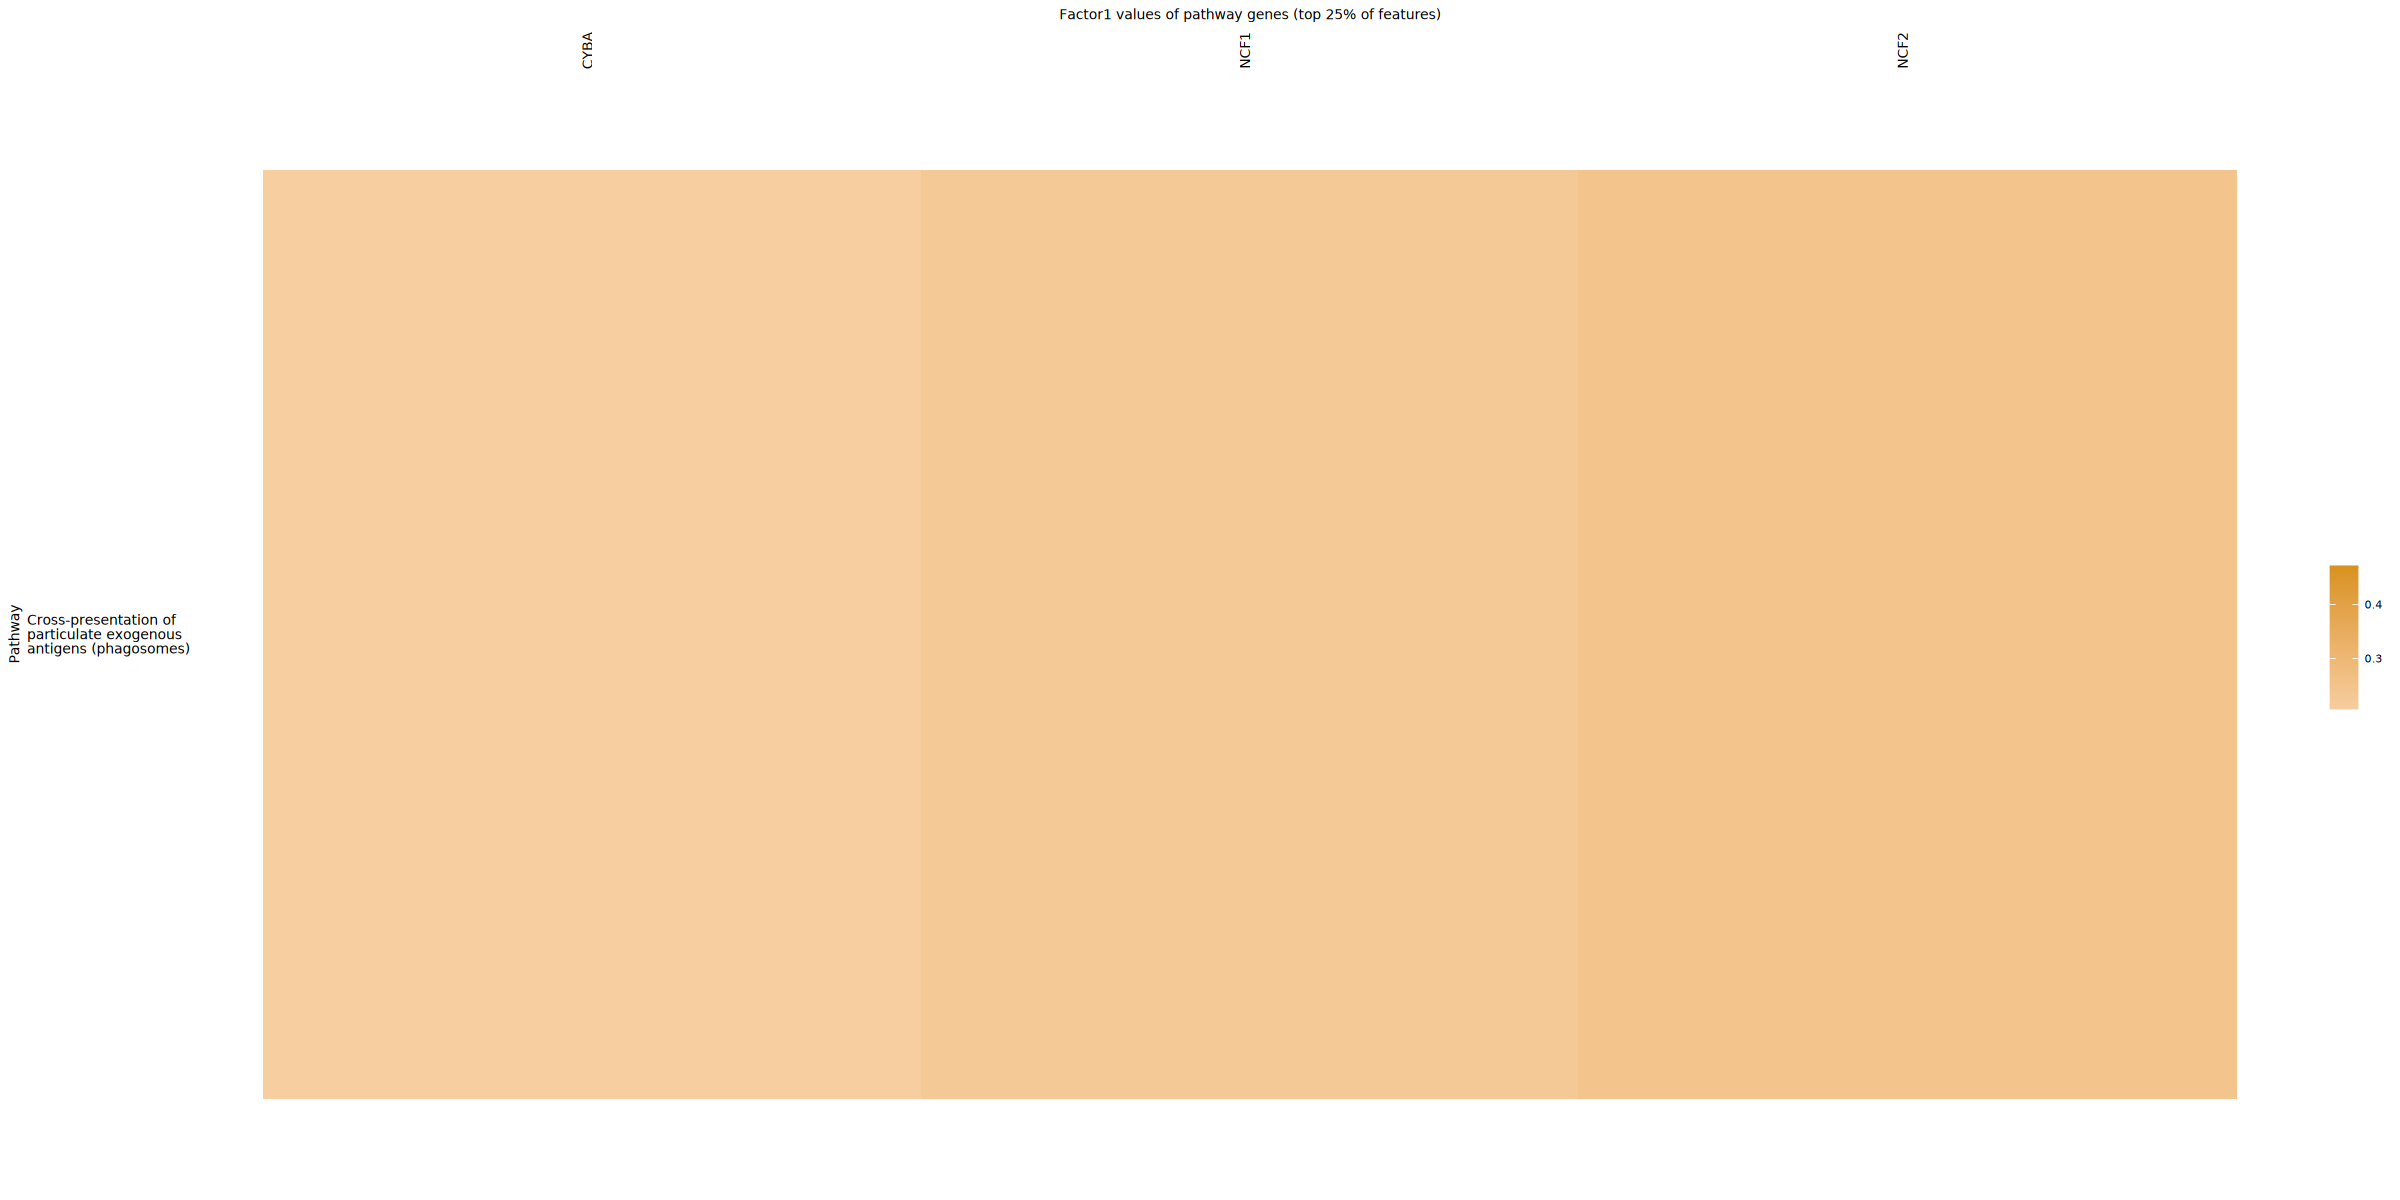

In [114]:
options(repr.plot.width=20, repr.plot.height=10)
pathways_sum_plot[[i]] +  scale_y_discrete(labels = label_wrap(25))

In [115]:
## Plot factor values for all genes

In [116]:
pathways_detail_plot = list()

In [117]:
### Visualized the exact factor values of the genes
for(i in unique(pathways_vis_genes$variable)){
    # Specific Text Descriptions:
    xlabel = xlab('Gene') 
    ylabel = ylab('View')

    plot_data_cluster = unique(pathways_vis_genes[pathways_vis_genes$variable == i,c('gene', 'variable', 'type','view',  'variable_name', 'factor_value', 'factor_value_direction')])

    pathways_detail_plot[[i]] = ggplot(plot_data_cluster, aes(gene,  view, fill= factor_value)) + 
        plot_config_heatmap + 
        geom_tile() + 
        scale_fill_gradient2(low = "#1D2ED8", mid = "white", high ="#D8911D", midpoint = 0)  + 
        scale_x_discrete(position = "top") +
        theme(axis.text.x = element_text(angle = 90)) +
        xlabel +
        ylabel
}

In [118]:
#pathways_detail_plot[[i]]

In [119]:
### Combine plot and save

In [120]:
combined_plot = list()

In [121]:
for(i in 1:length(pathways_detail_plot)){
    combined_plot[[i]] = ggarrange(pathways_sum_plot[[i]],
              pathways_detail_plot[[i]] + theme(axis.text.x = element_blank(), axis.title.x =element_blank()), align = 'v', ncol = 1)
}

In [122]:
#combined_plot[[i]]

In [123]:
## Save the plot

In [124]:
figure_name = paste0( "FIG06_Pathways_and_Genes")

In [125]:
# Sizes of the plot
width_par = 8.07
height_par = 4

In [126]:
pdf(paste0('figures/06_figures/', figure_name, '_',   mofa_name, '.pdf'), width =width_par, height =height_par)

for(j in 1:length(combined_plot)){
        print( combined_plot[[j]])
        }
dev.off()   


png 
  2